## Plotting spacecraft trajectories over images 


authors C. Möstl, A. J. Weiss, M. Bauer

status September 2020: plots psp trajectory over single LASCO images obtained via sunpy HelioviewerClient()

Currently uses the environment "cmesig" from https://github.com/cmoestl/cme_signatures

with !pip install pfsspy==0.5.3

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.image import imread
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

import datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os

import sunpy
from sunpy.time import parse_time
import sunpy.data.sample
import sunpy.map
from sunpy.net.helioviewer import HelioviewerClient
from sunpy.map import Map
from sunpy.coordinates import frames
import drms
import glymur
import zeep

import astropy
import astropy.units as u

import astropy
import astropy.constants as const
from astropy.coordinates import SkyCoord


import heliopy
import heliopy.spice as spice
import heliopy.data.spice as spicedata

import glob

import py3dcore

#import astroquery


import warnings
warnings.filterwarnings('ignore')


### get PSP positions

In [17]:
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan(z/np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)


frame='HEEQ'
starttime = datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time = []
res_in_days=1/48.
while starttime < endtime:
    pspt_time.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_num=parse_time(pspt_time).plot_date

spice.furnish(spicedata.get_kernel('psp_pred'))
pspt=spice.Trajectory('SPP')
pspt.generate_positions(pspt_time,'Sun',frame)
psp_speed=pspt.speed.value
pspt.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=cart2sphere(pspt.x,pspt.y,pspt.z)
print('PSP pos')
print()

lon=np.degrees(psp_lon.value)
print(lon)
lat=np.degrees(psp_lat.value)
print(lat)
r=psp_r.value
print(r)
ptime=pspt_time

psp_x=pspt.x.value
psp_y=pspt.y.value
psp_z=pspt.z.value

PSP pos

[-0.26736573 -0.2756879  -0.28400928 ...  7.04771653  7.05028505
  7.05288513]
[6.47275143 6.47224984 6.47174814 ... 3.85815706 3.85817297 3.8581883 ]
[1.01317831 1.01317197 1.01316555 ... 0.51436421 0.5140078  0.51365099]


## single image test

In [18]:
hv = HelioviewerClient()
#look at data sources
#hv.get_data_sources()

#https://docs.sunpy.org/en/latest/guide/acquiring_data/helioviewer.html


############################### LASCO

# copy this in the console to get a list of viable data sources
#hv.get_data_sources())

t1='2012/07/23 04:00:00'

#file = hv.download_jp2('2020/08/01', observatory="SDO", instrument="AIA",    measurement="304") 
#file = hv.download_jp2('2017/05/23', observatory="STEREO_A", instrument="SECCHI", detector='COR2'  ,  measurement="white-light") 
#file = hv.download_jp2('2012/07/23 04:00:00', observatory="SOHO", instrument="LASCO", detector='C3'  ,  measurement="white-light") 
file = hv.download_jp2(t1, observatory="SOHO", instrument="LASCO", detector='C3',  measurement="white-light") 


las = Map(file)  

lasrot = las.rotate(angle=5 * u.deg)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.12file/s]


In [19]:
#get index of flyby
fs_start_ind=np.where(mdates.date2num(ptime) > mdates.date2num(datetime.datetime(2024, 12,24)))[0][0]
fs_end_ind=np.where(mdates.date2num(ptime) > mdates.date2num(datetime.datetime(2024, 12,25)))[0][0]

## initiate 3DCORE

In [20]:
t_launch = datetime.datetime(2012, 7,23, 0)

iparams_arr = np.array([[
    0,      # time offset
    90,    # l_1 (logitude) HEEQ
    20,    # l_2 (latitude)
    60,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    600,    # v_0 (initial velocty in)
    -4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    20,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=0.1)
tm1 =  t_launch + datetime.timedelta(days=0.2)
tm2 =  t_launch + datetime.timedelta(days=0.3)
tm3 =  t_launch + datetime.timedelta(days=0.4)
tm4 =  t_launch + datetime.timedelta(days=0.5)




def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    #ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)
    
    
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u1, v1 = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
xs = np.cos(u1)*np.sin(v1)*scale
ys = np.sin(u1)*np.sin(v1)*scale
zs = np.cos(v1)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()    

## plot

coordinates of observer  <Helioprojective Frame (obstime=2012-07-23T03:54:07.231, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2012-07-23T03:54:07.231): (lon, lat, radius) in (deg, deg, AU)
    (0., 5.10195203, 1.01592031)>)>
WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 560.3442438414609  577.0040330078932  
PC1_1 PC1_2  : 0.9999990215655803  0.0013988809392355113  
PC2_1 PC2_2  : -0.0013988809392355183  0.9999990215655803  
CDELT : 0.015555555555555555  0.015555555555555555  
NAXIS : 1024  1024
timerange 2024-12-24 00:30:00 2024-12-25 00:30:00


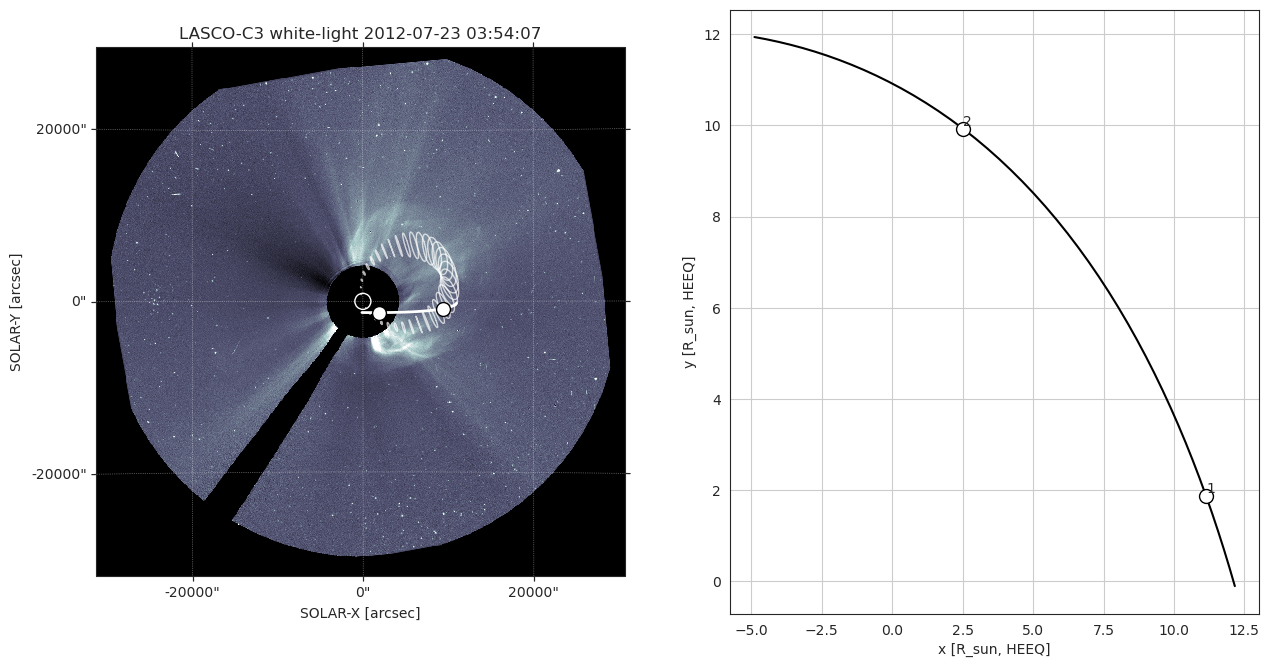

In [21]:

sns.set_style('white')
fig = plt.figure(1,figsize=(15, 8),dpi=100)


################################### plot 1

ax1 = plt.subplot(121, projection=lasrot)

print('coordinates of observer ',lasrot.coordinate_frame)
print(lasrot.wcs)

#plot image
lasrot.plot()
lasrot.draw_limb()
#plt.colorbar()

#psp position as SkyCoord object
px=psp_x[fs_start_ind:fs_end_ind]
py=psp_y[fs_start_ind:fs_end_ind]
pz=psp_z[fs_start_ind:fs_end_ind]

#scale AU to Rs
au2rs=(const.au/const.R_sun).value


pc = SkyCoord(px*u.AU, py*u.AU, pz*u.AU, frame='heliographic_stonyhurst',representation_type='cartesian')
ax1.plot_coord(pc, linestyle='solid', linewidth=2, color='white')



############## plot 3dcore in ax1 ** to do

model_obj.propagate(tm0)
wf_model = model_obj.visualize_wireframe(index=0)


mc= SkyCoord(wf_model.T[0,:,:]*u.AU, wf_model.T[1,:,:]*u.AU, wf_model.T[2,:,:]*u.AU, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(mc,color='white',linewidth=1,alpha=0.7)

################################## plot 2

ax2 = plt.subplot(122)

#ax2.plot(ptime[fs_start_ind:fs_end_ind],psp_r[fs_start_ind:fs_end_ind])
ax2.plot(px*au2rs,py*au2rs,'k')
ax2.set_xlabel('x [R_sun, HEEQ]')
ax2.set_ylabel('y [R_sun, HEEQ]')
ax2.grid(True)

#https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html
#c = SkyCoord(x=-72241.0*u.km, y=361206.1*u.km, z=589951.4*u.km, frame=frames.Heliocentric)


j=5
ax1.plot_coord(pc[j], 'o', markersize=10, mec='black', mfc='white')
ax2.plot(px[j]*au2rs,py[j]*au2rs,'o', markersize=10, mec='black', mfc='white')
ax2.text(px[j]*au2rs,py[j]*au2rs,'1',ha='left',va='bottom')

j=30
ax1.plot_coord(pc[j], 'o', markersize=10, mec='black', mfc='white')
ax2.plot(px[j]*au2rs,py[j]*au2rs,'o', markersize=10, mec='black', mfc='white')
ax2.text(px[j]*au2rs,py[j]*au2rs,'2',ha='left',va='bottom')





plt.savefig('results/imaging/lasco_test_' + str(j+1) + '.png')


print('timerange',ptime[fs_start_ind],ptime[fs_end_ind])

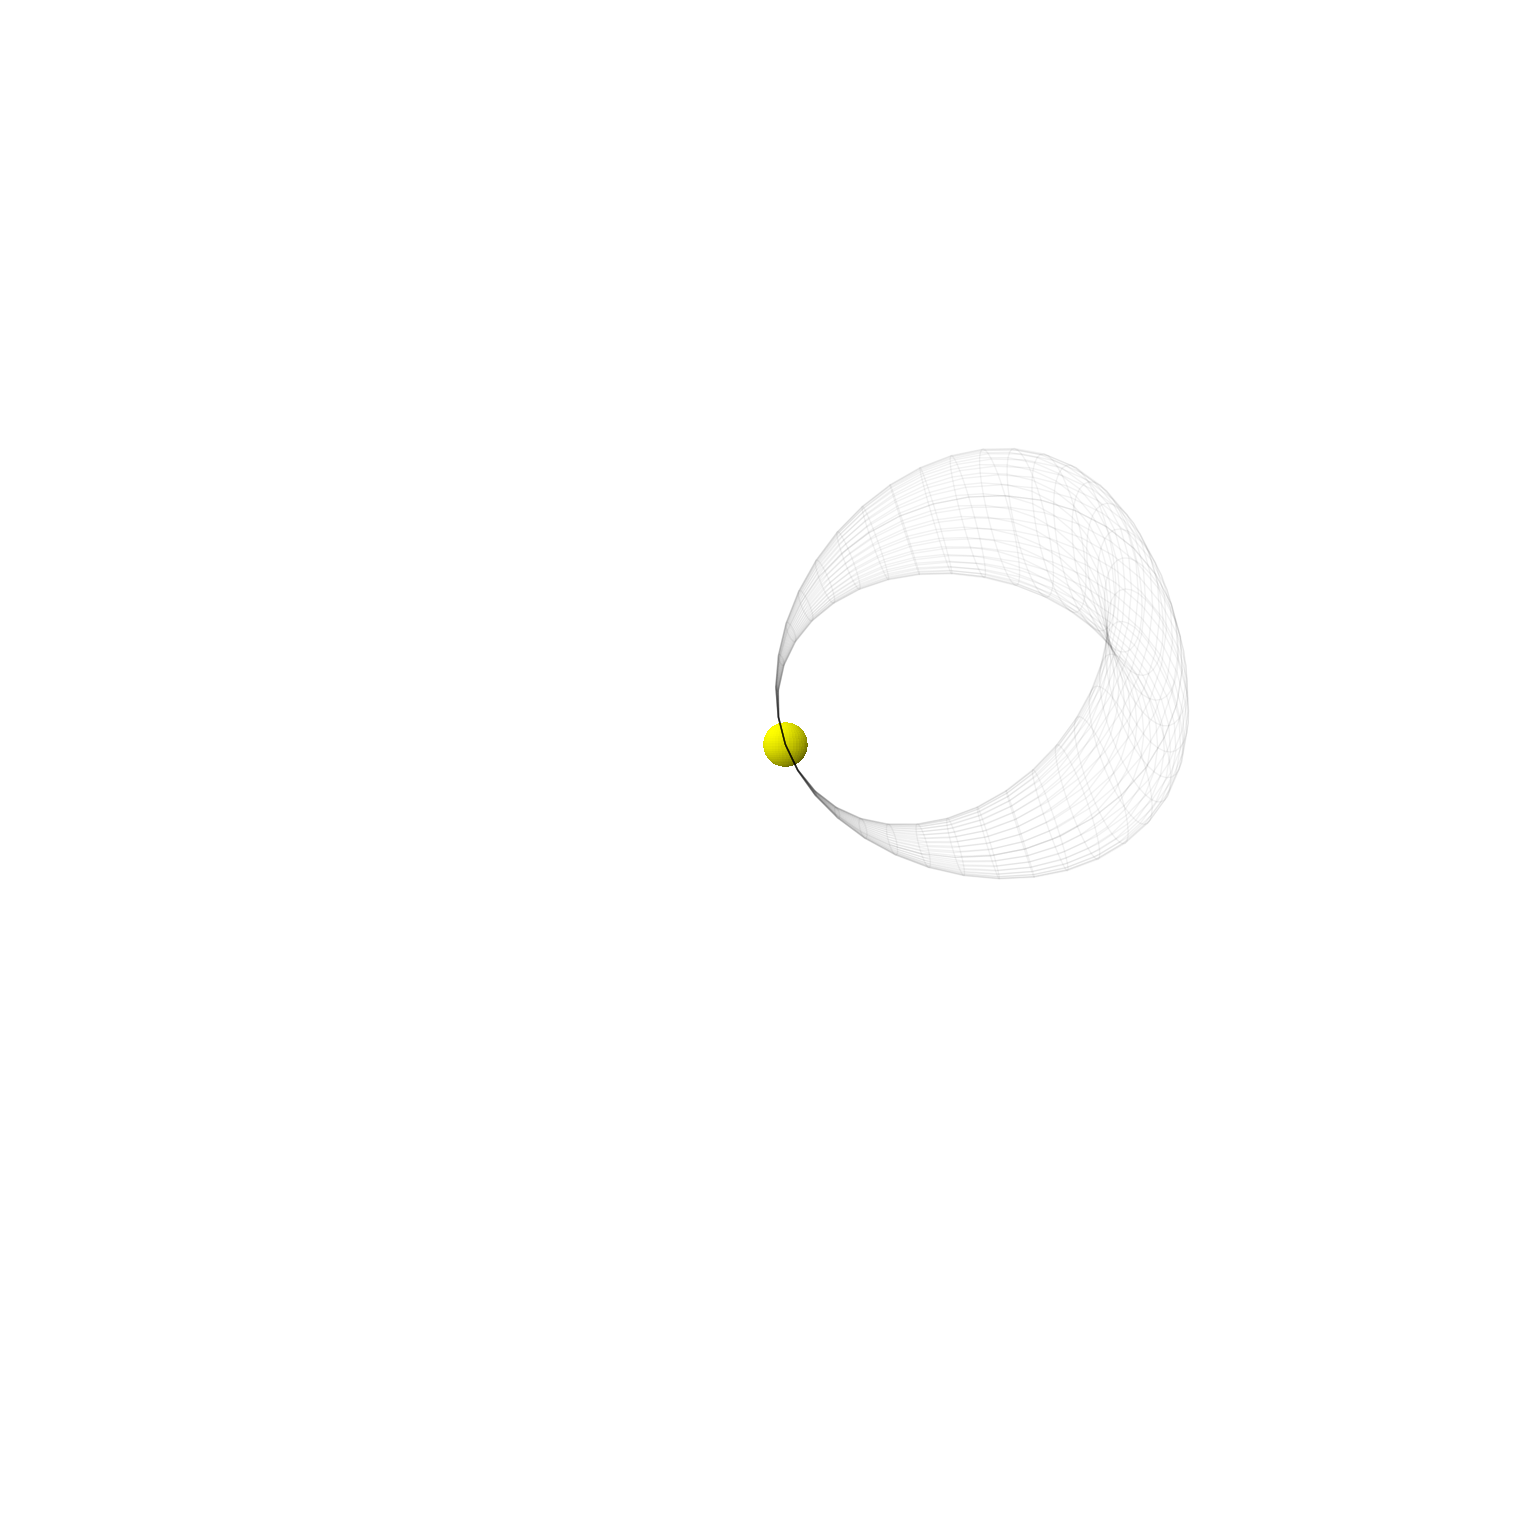

In [22]:

plt.figure(100,figsize=(20,20),dpi=100)
######################################### plot 3
#ax3 = plt.subplot(133,projection='3d')
ax3 = plt.subplot2grid((1, 1), (0, 0),projection='3d')  

#ax3.set_position([0.0,0,0.5,0.9], which='both')
plot_configure(ax3, view_azim=0, view_elev=0, view_radius=.1)
plot_3dcore(ax3, model_obj, tm1, color='black')




# older code











## get images

In [111]:
#https://docs.sunpy.org/en/latest/guide/acquiring_data/helioviewer.html

############################### LASCO
#t1=['2010/05/23 17:00:00', '2010/05/23 18:00:00', '2010/05/23 19:00:00', '2010/05/23 20:00:00', '2010/05/23 21:00:00', '2010/05/23 22:00:00', '2010/05/23 23:00:00', '2010/05/24 00:00:00', '2010/05/24 01:00:00', '2010/05/24 02:00:00', '2010/05/24 03:00:00', '2010/05/24 04:00:00', '2010/05/24 05:00:00', '2010/05/24 06:00:00', '2010/05/24 07:00:00']


start = '2012/07/23 04:00:00'
#start = '2010/05/23 16:00:00'
#start = '2017/09/10 15:00:00'
date = datetime.datetime.strptime(start, '%Y/%m/%d %H:%M:%S')
datelist = [date + i*datetime.timedelta(hours=0.5) for i in range(3)]
datelist_str = [datetime.datetime.strftime(datelist[i], '%Y/%m/%d %H:%M:%S') for i in range(len(datelist))]
t1 = datelist_str
#file = hv.download_jp2('2020/08/01', observatory="SDO", instrument="AIA",    measurement="304") 
#file = hv.download_jp2('2012/07/23 04:00:00', observatory="SOHO", instrument="LASCO", detector='C3'  ,  measurement="white-light") 
file = [hv.download_jp2(t1[i], observatory="SOHO", instrument="LASCO", detector='C3',  measurement="white-light") for i in range(len(t1))] 

las2 = Map(file)  

print('done')

#rotate the map
#lasrot = [las[i].rotate(angle=0 * u.deg) for i in range(len(t1))]

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  2.17file/s]


done


## plot single image

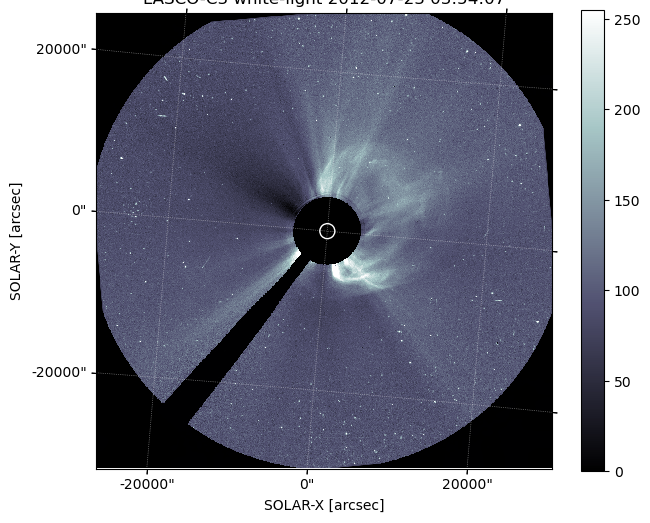

In [114]:
i=0

fig = plt.figure(1, figsize=(6,5), dpi=100)
ax = plt.subplot(111, projection=las2[i])

las2[i].plot()
las2[i].draw_limb()

plt.colorbar()
plt.tight_layout()





plt.savefig('results/imaging/lasco_test_' + str(i+1) + '.png')

In [21]:
############################### COR2

#file = [hv.download_jp2(t1[i], observatory="STEREO_A", instrument="SECCHI", detector='COR2'  ,  measurement="white-light") for i in range(len(t1))] 
#cor2 = Map(file)  
#rotate the map
#cor2rot = [cor2[i].rotate(angle=0 * u.deg) for i in range(len(t1))]

#fig = plt.figure(2, dpi=200)
#ax = plt.subplot(111, projection=cor2rot)

#cor2rot.plot()
#cor2rot.draw_limb()
#plt.colorbar()





################################### HMI
#hv = HelioviewerClient()
#filepath = hv.download_jp2(t1, observatory='SDO', instrument='HMI', measurement='magnetogram')
#hmi = Map(filepath)

#fig = plt.figure(3,dpi=200)
#ax = plt.subplot(111,projection=hmi)

#hmi.plot()
#plt.grid(None)

#hmi.draw_limb()
#hmi.draw_grid()
#plt.colorbar()

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.98file/s]


In [ ]:
#HEEQ to Heliocentric Cartesian

#obs_lon = psp_lon
#obs_lat = psp_lat
#radius = psp_r

#x = pspt.y
#y = pspt.z*np.cos(obs_lat) - pspt.x*np.sin(obs_lat)
#z = pspt.z*np.sin(obs_lat) + pspt.x*np.cos(obs_lat)

In [ ]:
#Heliocentric Cartesian to Helioprojective Cartesian

#d = np.sqrt(x**2 + y**2+(psp_r-z)**2)
#theta_x = np.arctan2(x, psp_r-z)
#theta_y = np.arcsin(y/d)

In [ ]:
#Helioprojective Cartesian to Helioprojective Radial

#theta_rho = np.arctan2(np.cos(theta_y)*np.cos(theta_x), np.sqrt(np.cos(theta_y)**2*np.sin(theta_x)**2+np.sin(theta_y)**2))
#psi = np.arctan2(np.sin(theta_y), -np.cos(theta_y)*np.sin(theta_x))

In [ ]:
# Hier mounte ich meinen eigenen Google Drive um auf die dort gespeicherten .sav files zugreifen zu können

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/My Drive/COR2/')
#rotate the map
#cor2rot = cor2.rotate(angle=0 * u.deg)
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(2, dpi=400)


for i in range(len(t1)):
  ax = plt.subplot(111, projection=cor2[i])

  cor2[i].plot_settings['cmap'] = cm.get_cmap('viridis')
  cor2[i].plot_settings['norm'] = colors.LogNorm(80, cor2[i].max())

  cor2[i].plot()

  c = SkyCoord(psp_lon[2*57930:2*57930+len(t1)], psp_lat[2*57930:2*57930+len(t1)], psp_r[2*57930:2*57930+len(t1)], frame='heliographic_stonyhurst')
  ax.plot_coord(c, linestyle='solid', linewidth=2, color='crimson')
  ax.plot_coord(c[i], '8', markersize=5, mec='crimson', mfc='white')
  #cor2rot.draw_limb()
  #las.draw_grid()
  plt.colorbar()
  plt.savefig('cor2_' + str(i+1) + '.png')
  plt.close()
  #files.download('/cor2/cor2_' + str(i) + '.png')

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much l

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't.
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''.
 [sunpy.map.mapbase]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't.
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''.
 [sunpy.map.mapbase]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't.
Changed DATE-OBS from '2010/05/23T16:18:05.833' to '2010-05-23T16:18:05.833''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010/05/23T16:18:05.833' to '2010-05-23T16:18:05.833''.
 [sunpy.map.mapbase]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keywo

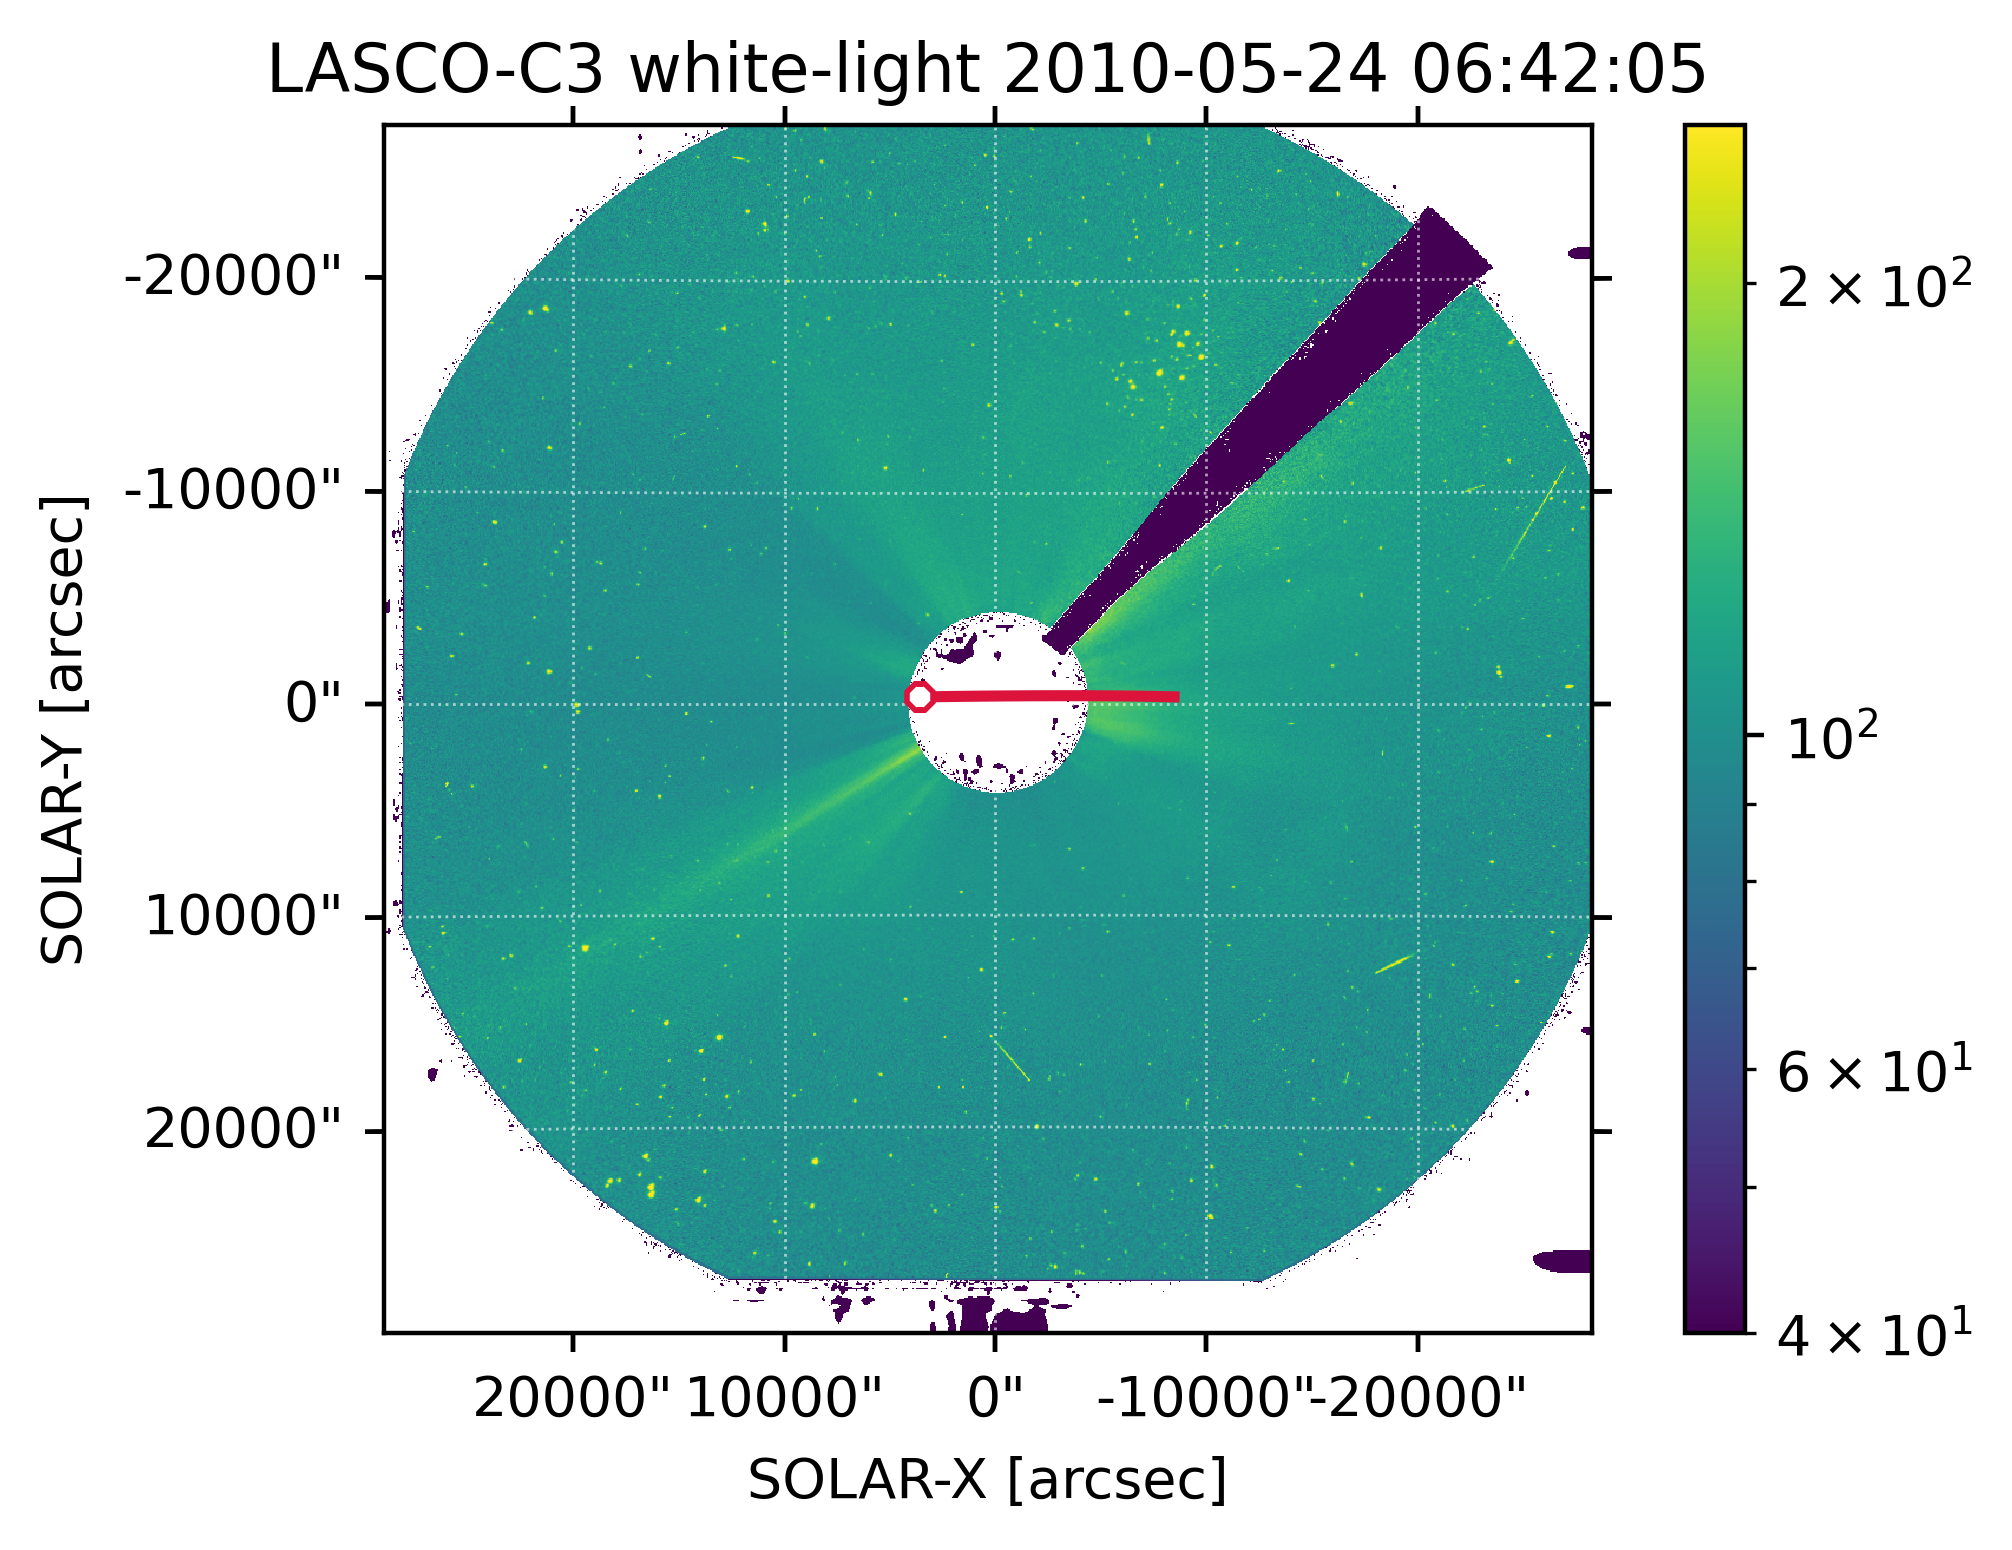

In [ ]:
os.chdir('/content/drive/My Drive/C3/')
#rotate the map
#cor2rot = cor2.rotate(angle=0 * u.deg)
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig = plt.figure(2, dpi=400)

k = 0

for i in range(len(t1)):

  if i in [7, 14, 19]:
    continue
  
  else:
    ax = plt.subplot(111, projection=las[i])

    las[i].plot_settings['cmap'] = cm.get_cmap('viridis')
    las[i].plot_settings['norm'] = colors.LogNorm(40, las[i].max())

    las[i].plot()

    c = SkyCoord(psp_lon[2*57930:2*57930+len(t1)], psp_lat[2*57930:2*57930+len(t1)], psp_r[2*57930:2*57930+len(t1)], frame='heliographic_stonyhurst')
    ax.plot_coord(c, linestyle='solid', linewidth=2, color='crimson')
    ax.plot_coord(c[i], '8', markersize=5, mec='crimson', mfc='white')
    #cor2rot.draw_limb()
    #las.draw_grid()
    plt.colorbar()
    plt.savefig('c3_' + str(k+1) + '.png')
    k = k + 1

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't.
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''.
 [sunpy.map.mapbase]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't.
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''. [astropy.wcs.wcs]
Changed DATE-OBS from '2010/05/23T15:42:06.885' to '2010-05-23T15:42:06.885''.
 [sunpy.map.mapbase]



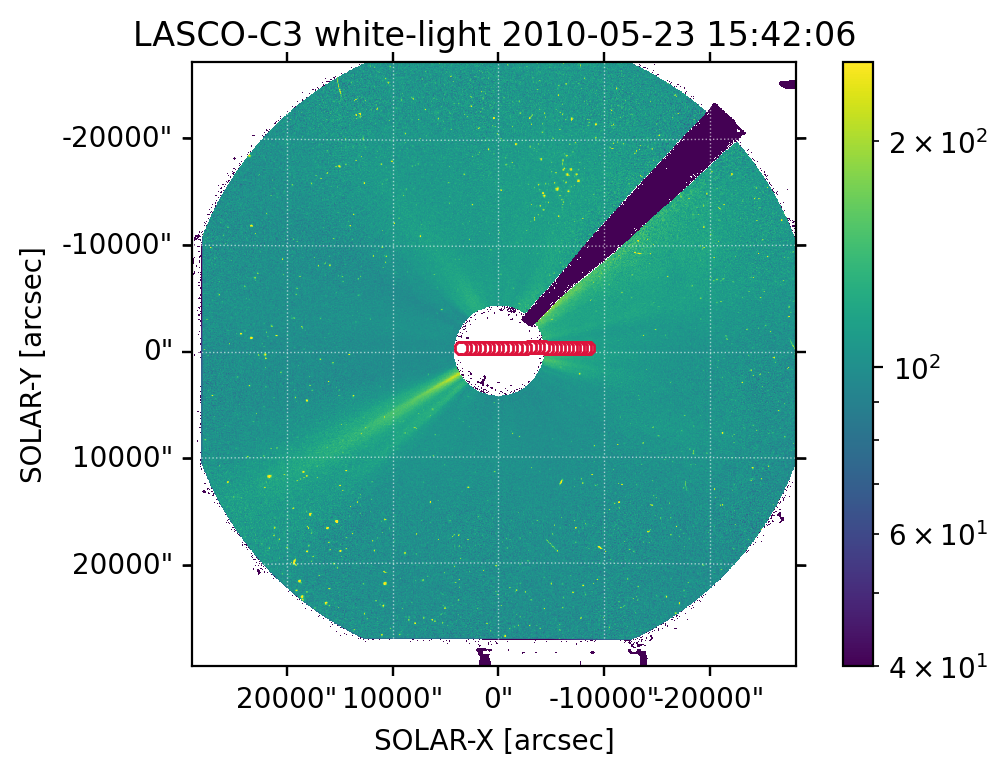

In [ ]:
os.chdir('/content/drive/My Drive/C3/')
#rotate the map
#cor2rot = cor2.rotate(angle=0 * u.deg)
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

i = 0
fig = plt.figure(2, dpi=200)


ax = plt.subplot(111, projection=las[i])

las[i].plot_settings['cmap'] = cm.get_cmap('viridis')
las[i].plot_settings['norm'] = colors.LogNorm(40, las[i].max())

las[i].plot()

c = SkyCoord(psp_lon[2*57930:2*57930+len(t1)], psp_lat[2*57930:2*57930+len(t1)], psp_r[2*57930:2*57930+len(t1)], frame=frames.HeliographicStonyhurst)


ax.plot_coord(c, linestyle='solid', linewidth=2, color='crimson')
ax.plot_coord(c[0:len(t1)], '8', markersize=5, mec='crimson', mfc='white')
#cor2rot.draw_limb()
#las.draw_grid()
plt.colorbar()

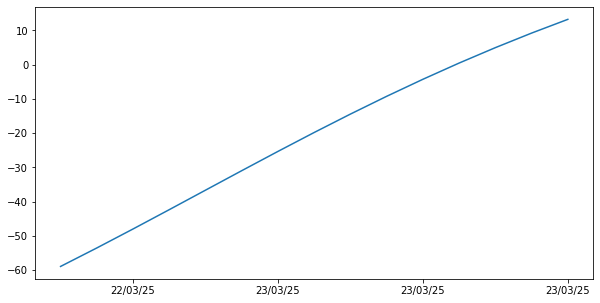

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pspt_time_num[57930:57945], psp_lon[57930:57945].to(u.deg))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax.xaxis_date()